# Install and import necessary libraries

In [1]:
%pip install ucimlrepo


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from pandas.plotting import table
from scipy.stats import chi2_contingency, pointbiserialr, pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Fetch dataset

In [3]:
statlog_german_credit_data = fetch_ucirepo(id=144) 
features = statlog_german_credit_data.data.features 
target = statlog_german_credit_data.data.targets

# EDA (Exploratory Data Analysis)

## Categorical Data

In [4]:
print("Dimensions of features:", features.shape)
print("Dimensions of target:", target.shape)

Dimensions of features: (1000, 20)
Dimensions of target: (1000, 1)


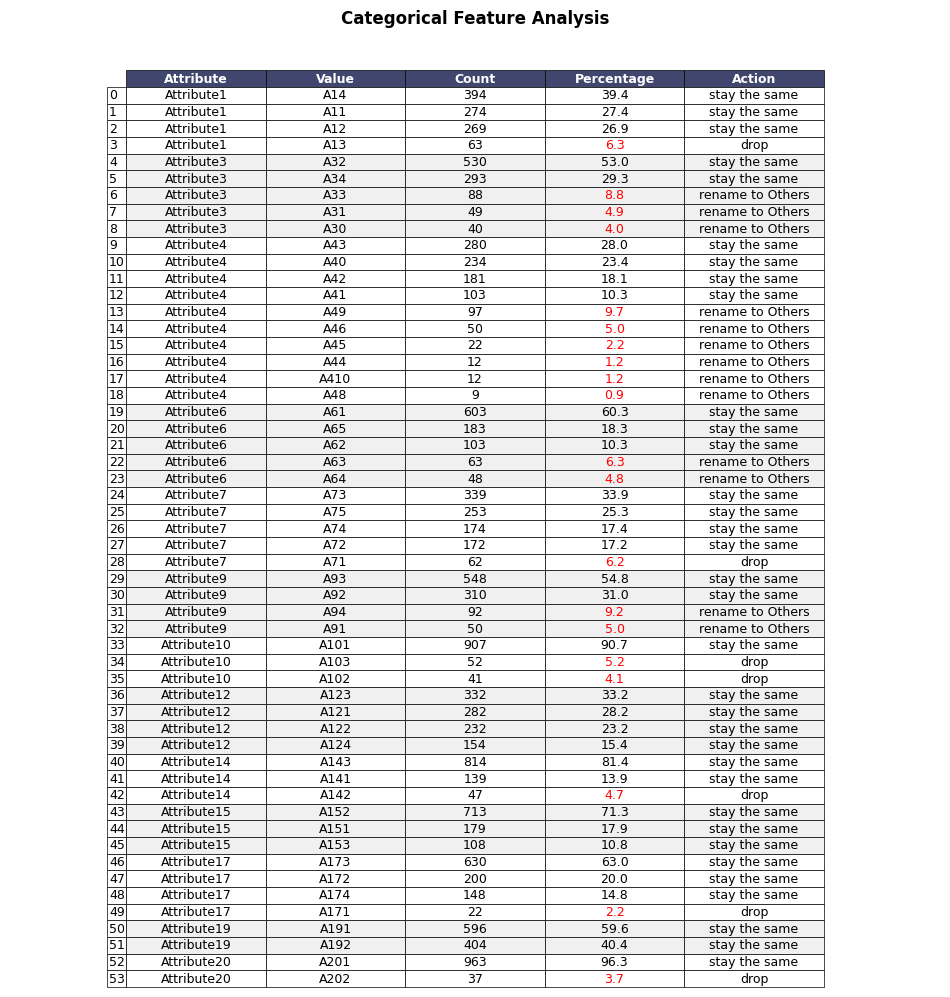

In [5]:
def calculate_percentages(features):
    """Calculate value counts and percentages for categorical features."""
    categorical_columns = features.select_dtypes(include='object').columns
    result_df = pd.DataFrame()

    for column in categorical_columns:
        value_counts = features[column].value_counts()
        percentages = (features[column].value_counts(normalize=True) * 100).round(2)

        df = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
        low_percentage = df[df['Percentage'] < 10]
        total_low_percentage = low_percentage['Percentage'].sum()

        # Define actions for low percentages
        df['Action'] = 'stay the same'
        if total_low_percentage > 10:
            df.loc[low_percentage.index, 'Action'] = 'rename to Others'
        else:
            df.loc[low_percentage.index, 'Action'] = 'drop'

        df['Attribute'] = column
        result_df = pd.concat([result_df, df])

    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'Value'}, inplace=True)
    result_df = result_df[['Attribute', 'Value', 'Count', 'Percentage', 'Action']]
    result_df['Percentage'] = pd.to_numeric(result_df['Percentage'])

    return result_df
        
def plot_categorical_table(result_df):
    """Plot a table showing the categorical feature analysis results."""
    fig, ax = plt.subplots(figsize=(12, 0.5))
    ax.axis('tight')
    ax.axis('off')

    the_table = table(ax, result_df, cellLoc='center', colWidths=[0.15] * len(result_df.columns))

    # Style the table
    for key, cell in the_table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
        cell.set_text_props(fontsize=10)
        if key[0] == 0:
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')

    current_attribute = None
    color_flag = True
    for i in range(1, len(result_df) + 1):
        if result_df.at[i-1, 'Attribute'] != current_attribute:
            current_attribute = result_df.at[i-1, 'Attribute']
            color_flag = not color_flag
        color = '#f0f0f0' if color_flag else '#ffffff'
        
        for j in range(len(result_df.columns)):
            the_table[(i, j)].set_facecolor(color)
            if j == 3 and result_df.iloc[i-1, j] < 10:
                the_table[(i, j)].set_text_props(color='red')

    for j in range(len(result_df.columns)):
        the_table[(0, j)].set_facecolor('#40466e')
        the_table[(0, j)].set_text_props(color='white')

    plt.title('Categorical Feature Analysis', weight='bold')
    plt.show()

# Calculate percentages and plot results
result_df = calculate_percentages(features)
plot_categorical_table(result_df)

In [6]:
# Rename and drop features based on actions
for _, row in result_df.iterrows():
    if row['Action'] == 'rename to Others':
        features.loc[features[row['Attribute']] == row['Value'], row['Attribute']] = 'Others'

indices_to_drop = set()
for _, row in result_df.iterrows():
    if row['Action'] == 'drop':
        indices_to_drop.update(features[features[row['Attribute']] == row['Value']].index)

features = features.drop(index=indices_to_drop)
target = target.drop(index=indices_to_drop)

In [7]:
# New dimensions of the DataFrames
print("Dimensions of features:", features.shape)
print("Dimensions of target:", target.shape)

Dimensions of features: (729, 20)
Dimensions of target: (729, 1)


## Numerical data

In [8]:
# Statistical Analysis
numerical_features = features.select_dtypes(include='number')
numerical_summary = numerical_features.describe()
print("Statistical Summary of Numerical Features:")
print(numerical_summary)

Statistical Summary of Numerical Features:
       Attribute2    Attribute5  Attribute8  Attribute11  Attribute13  \
count  729.000000    729.000000  729.000000   729.000000   729.000000   
mean    21.326475   3295.319616    3.009602     2.893004    35.274348   
std     12.273122   2817.357453    1.112450     1.102977    11.123380   
min      4.000000    250.000000    1.000000     1.000000    19.000000   
25%     12.000000   1388.000000    2.000000     2.000000    27.000000   
50%     18.000000   2333.000000    3.000000     3.000000    33.000000   
75%     24.000000   3976.000000    4.000000     4.000000    42.000000   
max     72.000000  15945.000000    4.000000     4.000000    74.000000   

       Attribute16  Attribute18  
count   729.000000   729.000000  
mean      1.422497     1.156379  
std       0.578781     0.363463  
min       1.000000     1.000000  
25%       1.000000     1.000000  
50%       1.000000     1.000000  
75%       2.000000     1.000000  
max       4.000000     2.00

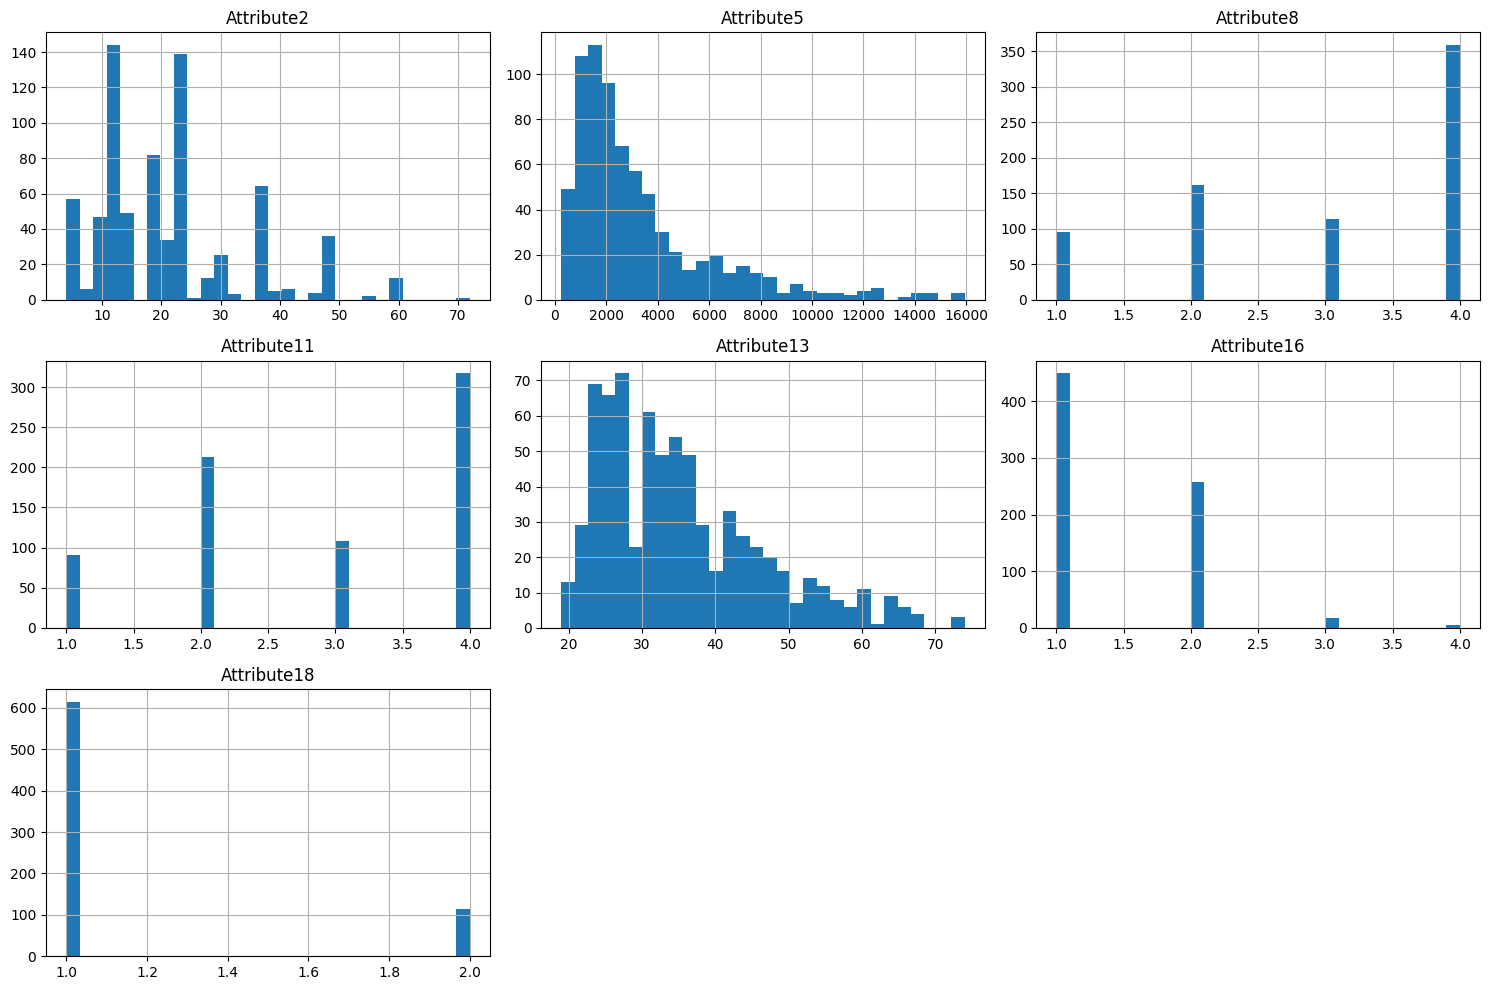

In [9]:
# Histogram of numerical features
numerical_features.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

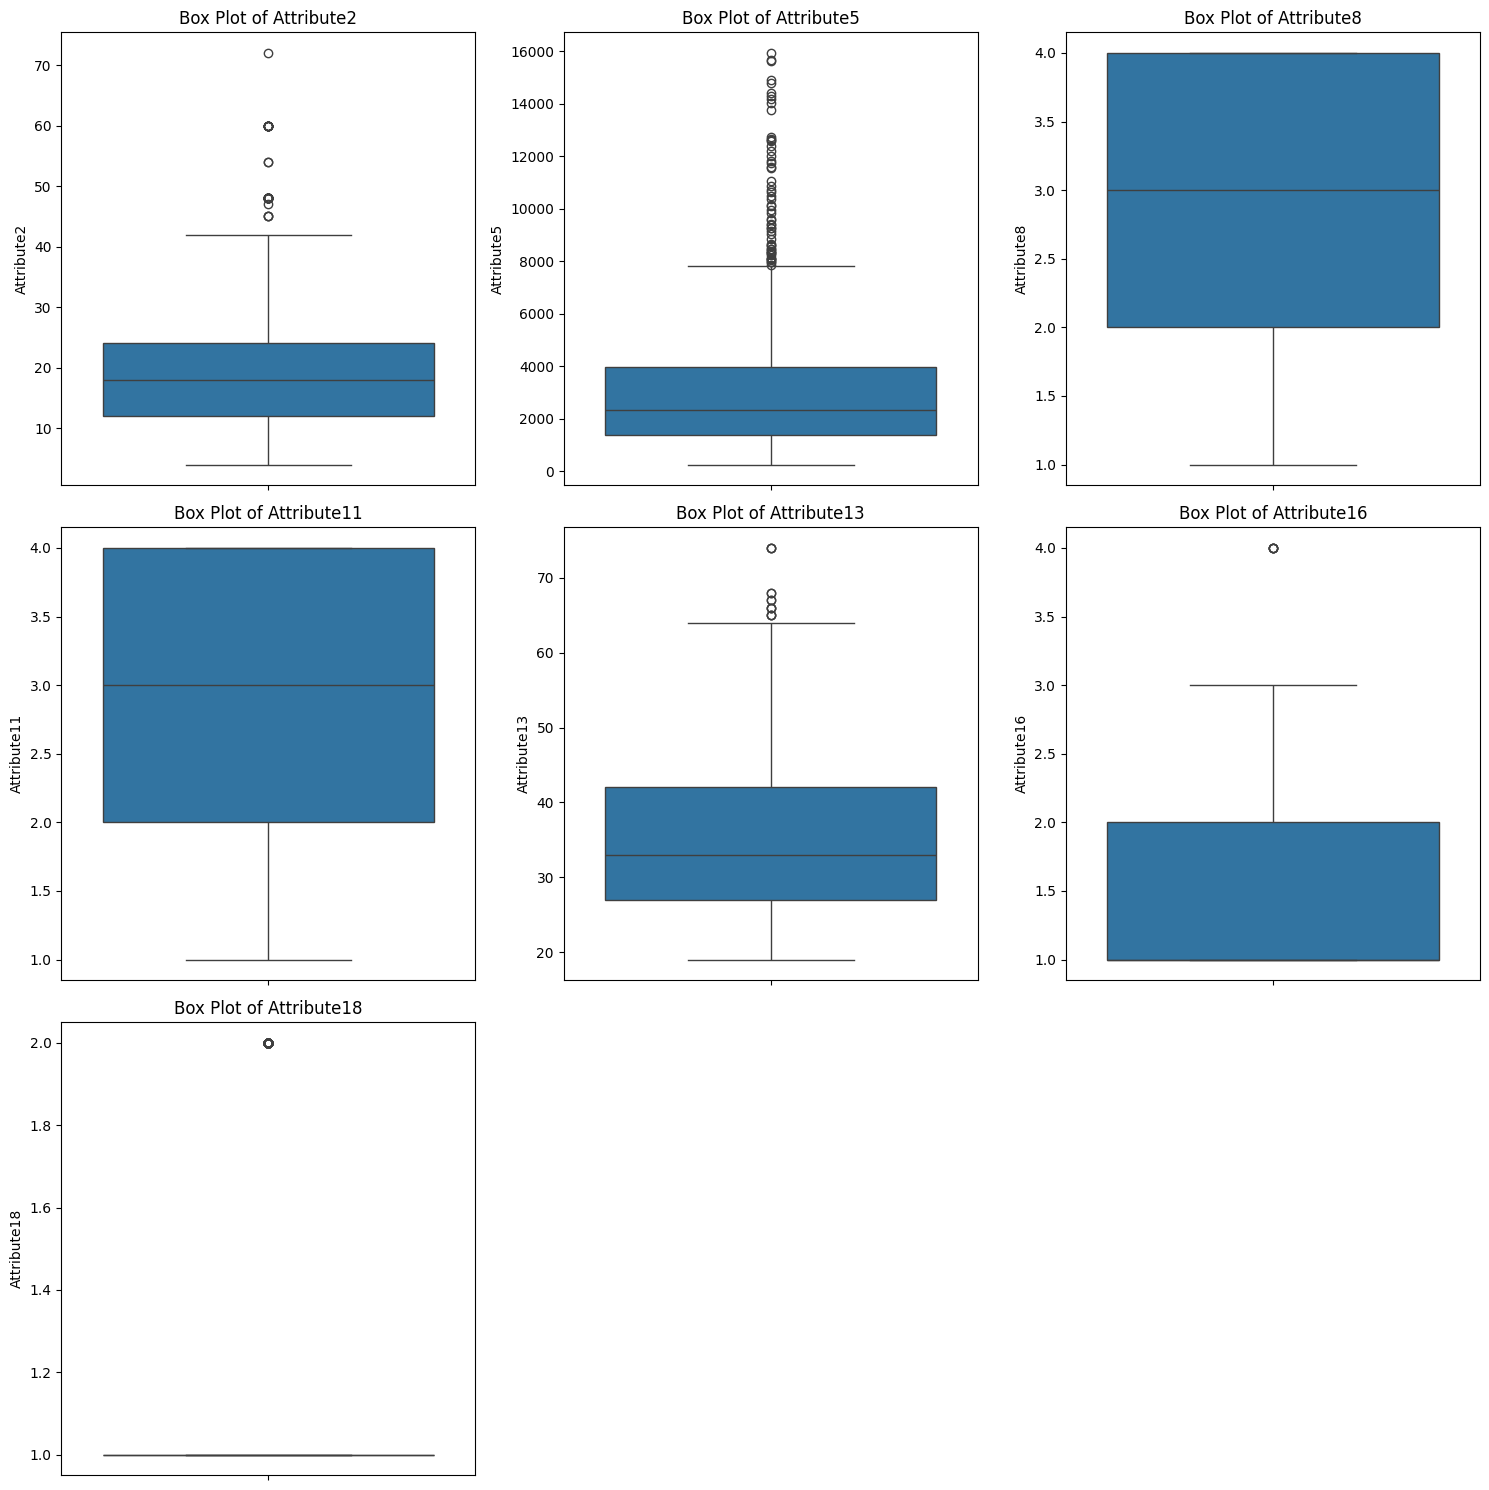

In [10]:
# Box plots for numerical features
num_features = len(numerical_features.columns)
fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))
axes = axes.flatten()

for i, column in enumerate(numerical_features.columns):
    sns.boxplot(y=numerical_features[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
def remove_outliers_z_score(df, columns, threshold=3):
    """Remove outliers using Z-score method."""
    mask = np.ones(len(df), dtype=bool)
    
    for column in columns:
        z_scores = (df[column] - df[column].mean()) / df[column].std()
        mask &= (np.abs(z_scores) < threshold)
    
    return df[mask]

# Remove outliers from specified columns
features = remove_outliers_z_score(features, ['Attribute2', 'Attribute5', 'Attribute16'])
target = target.loc[features.index]

In [12]:
# New dimensions of the DataFrames
print("Dimensions of features:", features.shape)
print("Dimensions of target:", target.shape)

# Reset the index of the dfs
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

Dimensions of features: (696, 20)
Dimensions of target: (696, 1)


## Target Data

In [13]:
# Update target variable
target.replace(2, 0, inplace=True)

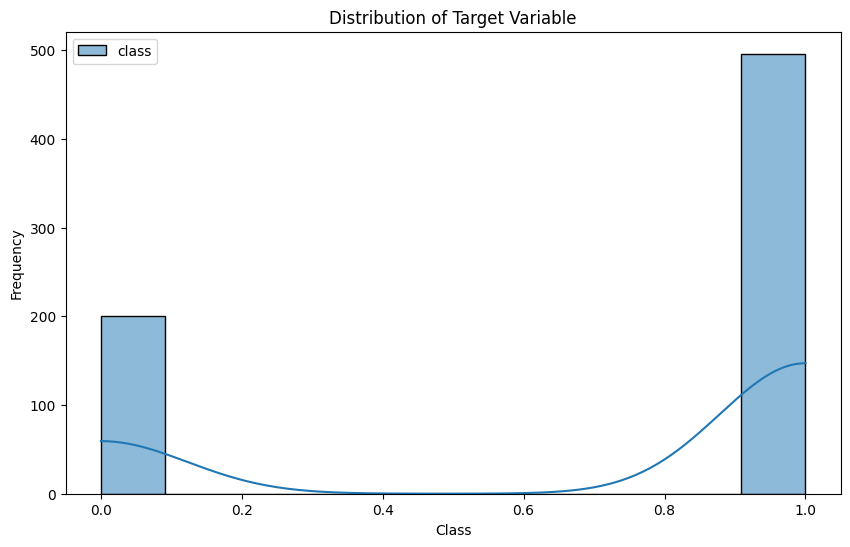

In [14]:
# Histogram of target variable
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

## Correlations

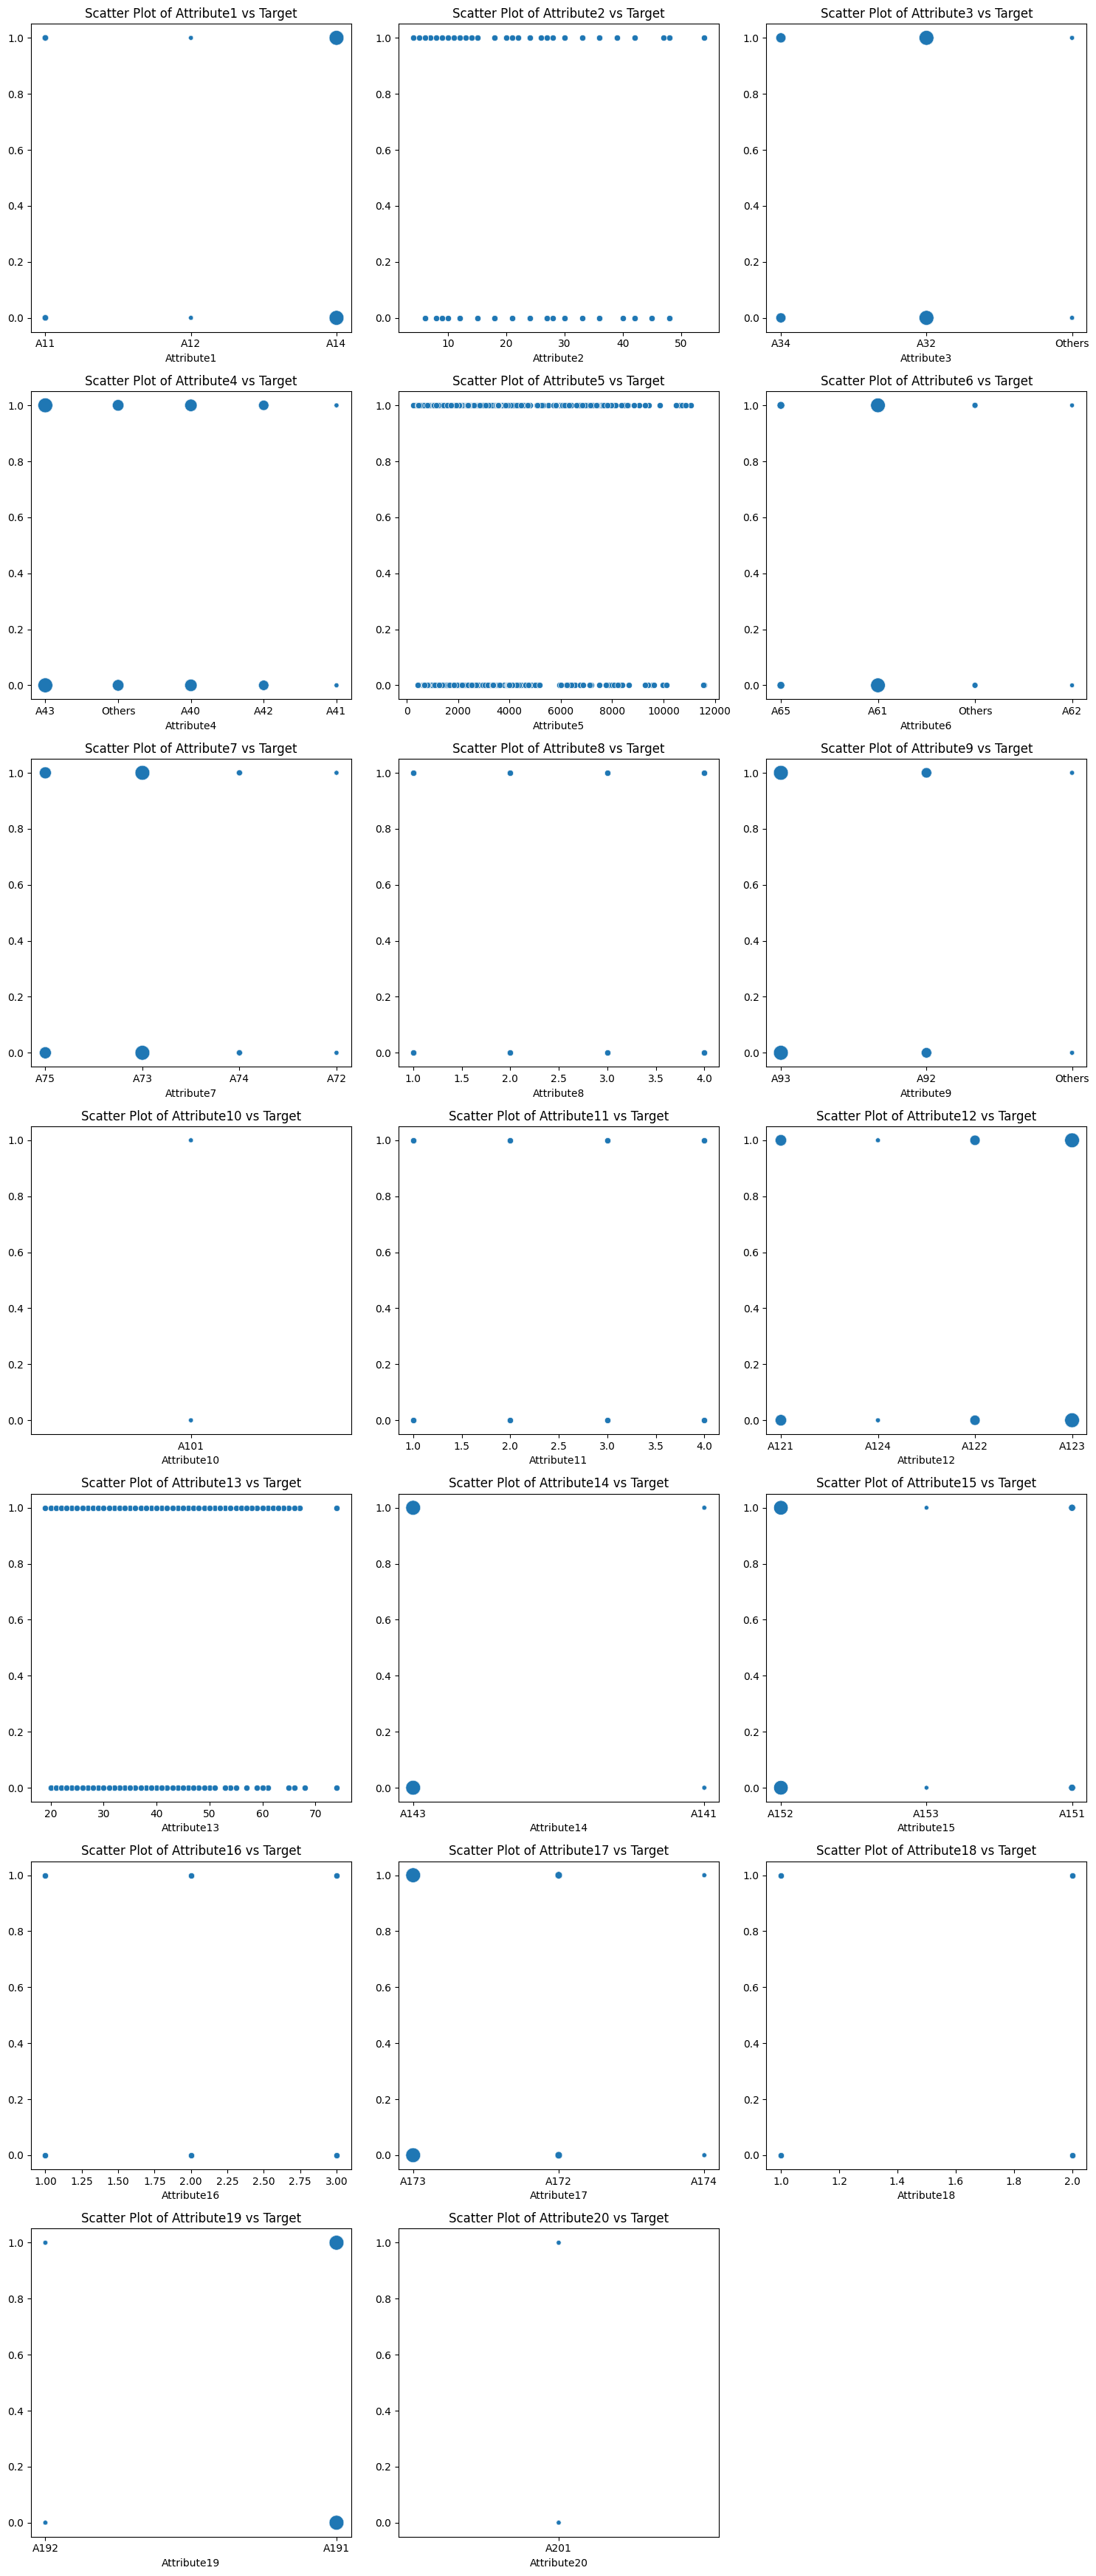

In [15]:
def plot_features(features, target):
    """Create scatter plots for features against the target variable."""
    num_features = len(features.columns)
    fig, axes = plt.subplots(nrows=(num_features + 2) // 3, ncols=3, figsize=(15, 5 * ((num_features + 2) // 3)))
    axes = axes.flatten()

    for i, column in enumerate(features.columns):
        if features[column].dtype == 'object':
            size_counts = features[column].value_counts()
            sizes = size_counts[features[column]].values * 10
            sns.scatterplot(x=features[column], y=target, ax=axes[i], size=sizes, sizes=(20, 200), legend=None)
        else:
            sns.scatterplot(x=features[column], y=target, ax=axes[i])
        axes[i].set_title(f'Scatter Plot of {column} vs Target')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function to plot features
plot_features(features, target.values.ravel())

### Categorical Features

In [16]:
# Chi-Squared Test for Categorical Features
target_flatten = target.values.ravel() 
results = []

categorical_columns = features.select_dtypes(include='object').columns
for col in categorical_columns:
    contingency_table = pd.crosstab(features[col], target_flatten)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    results.append({'Feature': col, 'p-value': p})

results_df = pd.DataFrame(results)

# Calculate Cramér's V
cramers_v_results = []
for _, row in results_df.iterrows():
    col = row['Feature']
    p_value = row['p-value']
    
    contingency_table = pd.crosstab(features[col], target_flatten)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    cramers_v = np.sqrt(phi2 / min(k-1, r-1)) if min(k-1, r-1) > 0 else np.nan
    
    significant = p_value < 0.05
    correlation = cramers_v
    
    cramers_v_results.append({
        'Feature': col,
        'p-value': p_value,
        'Significant': significant,
        'Cramér\'s V': correlation
    })

cramers_v_df = pd.DataFrame(cramers_v_results)

# Display the final organized results table
cramers_v_df

,Feature,p-value,Significant,Cramér's V
0,Attribute1,9.478150e-25,True,0.398689
1,Attribute3,3.503077e-09,True,0.236532
2,Attribute4,7.613761e-04,True,0.165529
3,Attribute6,9.825850e-06,True,0.193048
4,Attribute7,4.239950e-04,True,0.161162
5,Attribute9,1.650925e-02,True,0.108594
6,Attribute10,1.000000e+00,False,NaN
7,Attribute12,4.863698e-03,True,0.136128
8,Attribute14,1.316626e-03,True,0.121763
9,Attribute15,1.127856e-03,True,0.139657


### Numerical Features

In [17]:
# Analyze Numerical Features
numerical_columns = features.select_dtypes(exclude='object').columns
numerical_results = []
alpha = 0.05

for col in numerical_columns:
    pb_correlation, pb_p_value = pointbiserialr(target_flatten, features[col])
    pb_significant = pb_p_value < alpha
    pearson_corr, pearson_p = pearsonr(target_flatten, features[col])
    pearson_significant = pearson_p < alpha
    spearman_corr, spearman_p = spearmanr(target_flatten, features[col])
    spearman_significant = spearman_p < alpha

    numerical_results.append({
        'Feature': col,
        'Point Biserial p-value': pb_p_value,
        'Significant (PB)': pb_significant,
        'Point Biserial Correlation': pb_correlation,
        'Pearson p-value': pearson_p,
        'Significant (Pearson)': pearson_significant,
        'Pearson Correlation': pearson_corr,
        'Spearman p-value': spearman_p,
        'Significant (Spearman)': spearman_significant,
        'Spearman Correlation': spearman_corr,
    })

numerical_results_df = pd.DataFrame(numerical_results)

# Display the results
print("Numerical Feature Correlations:")
numerical_results_df

Numerical Feature Correlations:


,Feature,Point Biserial p-value,Significant (PB),Point Biserial Correlation,Pearson p-value,Significant (Pearson),Pearson Correlation,Spearman p-value,Significant (Spearman),Spearman Correlation
0,Attribute2,3.014320e-07,True,-0.192694,3.014320e-07,True,-0.192694,0.000004,True,-0.174308
1,Attribute5,4.405047e-02,True,-0.076351,4.405047e-02,True,-0.076351,0.233897,False,-0.045179
2,Attribute8,2.161890e-02,True,-0.087059,2.161890e-02,True,-0.087059,0.024159,True,-0.085457
3,Attribute11,4.225142e-01,False,-0.030450,4.225142e-01,False,-0.030450,0.453155,False,-0.028480
4,Attribute13,2.467848e-03,True,0.114576,2.467848e-03,True,0.114576,0.000075,True,0.149490
5,Attribute16,1.493243e-02,True,0.092230,1.493243e-02,True,0.092230,0.016293,True,0.091033
6,Attribute18,8.010417e-01,False,-0.009569,8.010417e-01,False,-0.009569,0.801042,False,-0.009569


In [18]:
# Keep only significant features
features = features[['Attribute1', 'Attribute2', 'Attribute3', 'Attribute6', 'Attribute13']]

# Dataset

In [19]:
# Convert features to DataFrame for easier manipulation
features = pd.DataFrame(features, columns=statlog_german_credit_data.feature_names)
target = target_flatten

# Encode categorical features
label_encoders = {}
for column in features.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le  # Store the label encoder for inverse transforming later

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Output the sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 556
Testing set size: 140


 Categorical variables are converted into numerical values using label encoding, which is essential for algorithms that require numerical input. This step is necessary because Naive Bayes requires all features to be numerical.

# Naive Bayes Classifier

For this dataset, we can choose one of the Naive Bayes classifiers. Given that the target variable is binary and the features include both continuous and discrete variables, we can use Bernoulli Naive Bayes, which is suitable for binary features.

In [20]:
# Initialize the Bernoulli Naive Bayes classifier
model = BernoulliNB()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Model Accuracy: 0.74
Confusion Matrix:
[[12 23]
 [14 91]]
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.34      0.39        35
           1       0.80      0.87      0.83       105

    accuracy                           0.74       140
   macro avg       0.63      0.60      0.61       140
weighted avg       0.71      0.74      0.72       140



- **Precision (Class 0):** 0.46 means that when the model predicts class 0, it is correct 46% of the time.
- **Recall (Class 0):** 0.34 means that the model identifies 34% of actual class 0 instances.
- **F1-Score (Class 0):** 0.39 is the harmonic mean of precision and recall, providing a single metric for class performance.
- **Precision (Class 1):** 0.80 means that when the model predicts class 1, it is correct 80% of the time.
- **Recall (Class 1):** 0.87 means that the model identifies 87% of actual class 1 instances.
- **F1-Score (Class 1):** 0.83 is a good score, indicating a balance between precision and recall for class 1.
- **Macro Average:** The average performance across both classes, treating them equally.
- **Weighted Average:** Takes the support (number of instances) into account, giving more weight to the larger class (class 1).

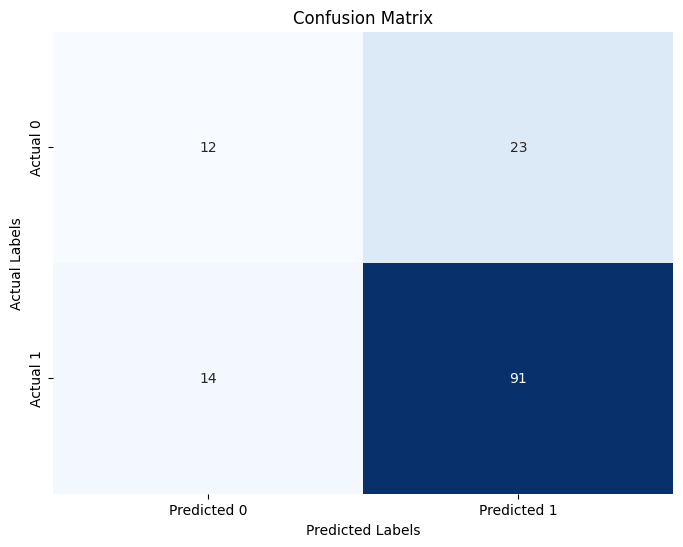

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

# Show the plot
plt.show()


# Model Debugging: Cross-Validation

In [22]:
# Initialize the Bernoulli Naive Bayes classifier
model = BernoulliNB()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())


Cross-Validation Scores: [0.71428571 0.69064748 0.76258993 0.74100719 0.78417266]
Mean Cross-Validation Score: 0.7385405960945529


# Development of the Second Model: Logistic Regression

Since i have already implemented Bernoulli Naive Bayes, let's explore Logistic Regression as the alternative model.
Also Logistic regression is inherently designed for binary classification problems, making it a natural fit for the target variable.

In [23]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Fit the model on the training set
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Calculate the confusion matrix
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)

# Generate a classification report
class_report_logistic = classification_report(y_test, y_pred_logistic)

# Print 
print("Logistic Regression Model Accuracy:")
print(accuracy_score(y_test, y_pred_logistic))
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_logistic)
print("\nLogistic Regression Classification Report:")
print(class_report_logistic)


Logistic Regression Model Accuracy:
0.7571428571428571
Logistic Regression Confusion Matrix:
[[12 23]
 [11 94]]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.34      0.41        35
           1       0.80      0.90      0.85       105

    accuracy                           0.76       140
   macro avg       0.66      0.62      0.63       140
weighted avg       0.73      0.76      0.74       140



In [24]:
# Perform 5-fold cross-validation
logistic_cv_scores = cross_val_score(logistic_model, features, target, cv=5, scoring='accuracy')

# Print cross-validation scores for Logistic Regression
print("Logistic Regression Cross-Validation Scores:", logistic_cv_scores)
print("Mean Cross-Validation Score for Logistic Regression:", logistic_cv_scores.mean())

Logistic Regression Cross-Validation Scores: [0.77857143 0.69784173 0.78417266 0.74820144 0.77697842]
Mean Cross-Validation Score for Logistic Regression: 0.7571531346351491


# Conclusions

The conclusions presented in this Jupyter Notebook are based on the results obtained from the first run of the code. It is important to note that these conclusions might change between runs due to the inherent randomness in some algorithms or the variability of the dataset. Therefore, it is recommended to perform multiple runs or use cross-validation techniques to obtain more reliable and robust conclusions.

**Model Accuracy:**
- The Logistic Regression model has a higher accuracy (0.76) compared to the Bernoulli Naive Bayes model (0.74). This suggests that the Logistic Regression model is better at predicting the target variable on the test set.

**Confusion Matrix:**
- True Negatives (TN): Both models correctly classified 12 instances of class 0.
- False Positives (FP): Both models misclassified 23 instances of class 0 as class 1.
- False Negatives (FN): The Logistic Regression model has fewer FN (11) compared to the Bernoulli model (14), indicating it was better at identifying positive instances.
- True Positives (TP): The Logistic Regression model identified 94 instances correctly as class 1, while the Bernoulli model identified 91.

**Classification Report:**
-   The Logistic Regression model shows improved precision and recall for class 1, suggesting it is more effective in identifying positive cases.
-   Although the precision for class 0 is higher in the Logistic Regression model (0.52 vs. 0.46), both models struggle with recall for class 0 (0.34), indicating that they may not perform well on identifying negative instances.

 **Cross-Validation Scores:**
- The Logistic Regression model has a higher mean cross-validation score, indicating better generalization across different subsets of the data.


Based on the results, the **Logistic Regression model is better** than the Bernoulli Naive Bayes model. It has a higher accuracy, better performance on the confusion matrix, and superior cross-validation scores. The ability to correctly identify more positive instances (lower false negatives) also adds to its efficacy.

# Further Model Refinement

**Additional Data Treatment**

**Considerations for Additional Data Treatment:**

1. **Feature Scaling:** Logistic regression may benefit from feature scaling (e.g., standardization or normalization) since it assumes a linear relationship and is sensitive to the scale of input features. In this case, scaling might not be crucial since the differences between numerical values are not extreme (e.g., not in the range of 1 to 100000). However, scaling could be considered in another study to explore potential benefits.

2. **Handling Class Imbalance:** If the dataset has class imbalance (more instances of one class than the other), consider techniques like:
    - **Oversampling:** Increase instances of the minority class (e.g., using SMOTE).
    - **Undersampling:** Reduce instances of the majority class.
    - **Class Weights:** Adjust class weights in the model to give more importance to the minority class.
   
   Initially, I addressed class imbalance by removing instances with less than 10% representation in a column. Increasing this threshold to 20% might improve the model, but given the dataset's limited size, it could also result in losing too much data.

3. **Feature Engineering:** Create new features that may capture more information relevant to the prediction task. For example, combining categorical variables or creating interaction terms between features.

**Justification:**

- **Improving Model Performance:** These treatments can help enhance model accuracy and robustness, especially in datasets with diverse feature scales and class distributions.
- **Reducing Overfitting:** Balancing classes and scaling features can help prevent overfitting, ensuring that the model generalizes better to unseen data.

By refining the data and enhancing the model, you can achieve better predictive performance and insights from the analysis. If you need further assistance with any of these steps, feel free to ask!